In [5]:
import numpy as np
import pandas as pd

import bs4 as bs
import urllib.request
import json
from bs4 import BeautifulSoup
import requests
import re

import MySQLdb, pickle
from sqlalchemy import create_engine

In [37]:
df = pd.DataFrame(columns = ['year', 'title','company','subname','mile','photos','video','exterior_color','interior_color','transmission','drivetrain','star','review_no','vendor','price'])

for page in range(1,10):
    url = 'https://www.cars.com/for-sale/searchresults.action/?page='+str(page)+'&perPage=100&rd=99999&searchSource=PAGINATION&showMore=true&sort=relevance&stkTypId=28881&zc=31216'

    sauce = urllib.request.urlopen(url).read()
    soup = bs.BeautifulSoup(sauce, 'lxml')

    specificSoup = soup.find_all('div', class_='listing-row__details')

    

    for div in specificSoup:
        name_index = div.find('h2', {'class' :'cui-delta listing-row__title'}).text
        name = name_index.split("\n")[1]

    
        year_index = re.findall('[0-9]{4}',name)[0:1]
        year = year_index[0]

        title_index = name.split(" ")[29:34]
        title = " ".join(title_index)

        company = title.split(" ")[0]
        subname = title.split(" ")[1]

        mile_index = div.find('span', {'class' : 'listing-row__mileage'}).text
        mile = mile_index.split("\n")[0]
        regex = re.compile("\d+")
        miles = regex.findall(mile) 
        mile = ''.join(miles)

        vendor_index =div.find('div',{'class' : 'listing-row__dealer-name listing-row__dealer-name-mobile'}).text
        vendor_group = vendor_index.split(' ')[0:4]

        vendor = ''
        for i in vendor_group:
            if i == '':continue
            elif re.findall('\n', i): vendor += re.sub('\n', '', i)
            else: vendor += " "+ i +" "

        photos_index = div.find('div', {'class' : 'media-count shadowed'}).text
        photos = re.findall('[0-9]{1,3}',photos_index.split("\n")[1])[0]

        video_index = div.find('div', {'class' : 'media-count shadowed'}).text
        try: 
            video = re.findall('[0-9]{1,3}',photos_index.split("\n")[2])[0]
        except:
            video = 0

        exterior_color = div.find('ul', {'class' : 'listing-row__meta'}).text
        exterior_color = re.sub('\n', ' ',exterior_color).split(" ")[4]

        interior_color = div.find('ul', {'class' : 'listing-row__meta'})
        interior_color = list(interior_color)[3].text.split(" ")[3:5]
        interior_color = " ".join(interior_color)
        interior_color = re.sub('/' , ' ' ,interior_color)

        transmission = div.find('ul', {'class' : 'listing-row__meta'})
        transmission = list(transmission)[5].text.split(" ")[2]
        if transmission == "automatic":
            transmission = "6-speed"

        

        drivetrain = div.find('ul', {'class' : 'listing-row__meta'})
        try:
            drivetrain = list(drivetrain)[7].text.split(" ")[2:5]
        except: 
            drivetrain = 'fwd'
        drivetrain = " ".join(drivetrain).lower()
        if drivetrain == 'rear wheel drive':
            drivetrain = 'rwd'
        elif drivetrain == 'front wheel drive':
            drivetrain = 'fwd'
        elif drivetrain == 'all wheel drive':
            drivetrain = '4wd'



        star_index =div.find('div',{'class' : 'dealer-rating-stars'}).text
        star = star_index.split(" ")[36]
        regex = re.compile("\d")
        star = regex.findall(star)[0] 


        review_index =div.find('span',{'class' : 'listing-row__review-number'}).text
        review_no = re.sub('\n', '',review_index.split(" ")[1])

        price_index = div.find('span', {'class' : 'listing-row__price'}).text
        price = price_index.split("\n")[1]
        regex = re.compile("\d")
        price = ''.join(regex.findall(price))
        price



        data = { 
                'year' : year,
                'title' : title.lower(),
                'company': company.lower(),
                'subname': subname.lower(),
                'mile' : mile,
                'photos': photos,
                'video' : video,
                'exterior_color' : exterior_color.lower(),
                'interior_color' : interior_color.lower(),
                'transmission' : transmission.lower(),
                'drivetrain' : drivetrain,
                'star': star,
                'review_no' : review_no,

                'vendor' : vendor.lower(),
                'price': price,
                    }


        df.loc[len(df)] = data
        
        df['transmission'] = df['transmission'].apply(lambda x: '6-speed' if x == 'automatic' or x == '6' else x)
        df['transmission'] = df['transmission'].apply(lambda x: 'x-speed' if x == 'continuously' or x == 'electronically' else x)
        df['drivetrain'] = df['drivetrain'].apply(lambda x: '4wd' if x == 'four wheel drive' or x == '4wd' or x=='4x4' else x)
        
df

,year,title,company,subname,mile,photos,video,exterior_color,interior_color,transmission,drivetrain,star,review_no,vendor,price
0,2012,mercedes-benz c 250 luxury,mercedes-benz,c,65374,32,1,black,cappuccino,7-speed,rwd,5,10,southern auto brokers,12998
1,2005,porsche 911 carrera s cabriolet,porsche,911,64034,32,1,silver,stone gray,6-speed,rwd,5,11,united imports inc,30990
2,2010,mercedes-benz e 550,mercedes-benz,e,58204,32,1,iridium,black,7-speed,rwd,5,26,inetwork auto group,18549
3,2007,chevrolet avalanche lt w/3lt,chevrolet,avalanche,41631,27,1,summit,ebony light cashmere,4-speed,4wd,5,21,minton motor cars,17999
4,2016,volkswagen jetta 1.4t s,volkswagen,jetta,46042,25,1,cardinal,black,6-speed,fwd,5,18,hertz car sales winston-salem,9998
5,2017,kia sportage lx,kia,sportage,43989,26,1,sparkling,black,6-speed,fwd,5,18,hertz car sales winston-salem,14998
6,2017,chevrolet malibu 1lt,chevrolet,malibu,47450,25,1,cajun,jet black,6-speed,fwd,5,42,hertz car sales orlando,13988
7,2016,nissan sentra s,nissan,sentra,48058,25,1,gray,gray,6-speed,fwd,5,42,hertz car sales orlando,9988
8,2008,volvo v70 3.2,volvo,v70,169982,32,1,burgundy,tan,6-speed,fwd,5,16,sharpmotors,4750
9,2009,pontiac g8 gt,pontiac,g8,88919,27,1,silver,black,6-speed,rwd,5,8,ez choice auto sales,14999


In [38]:
df.transmission.unique()

array(['7-speed', '6-speed', '4-speed', '1-speed', '5-speed', '8-speed',
       'x-speed', '9-speed', '10-speed', 'xtronic', 'cvt', 'a', 'next',
       'awd', 'rwd', '8', '5', 'electronic', '4wd', 'aisin', 'fwd'], dtype=object)

In [39]:
df.drivetrain.unique()

array(['rwd', '4wd', 'fwd', 'awd', '2wd', 'f w d', 'all-wheel drive'], dtype=object)

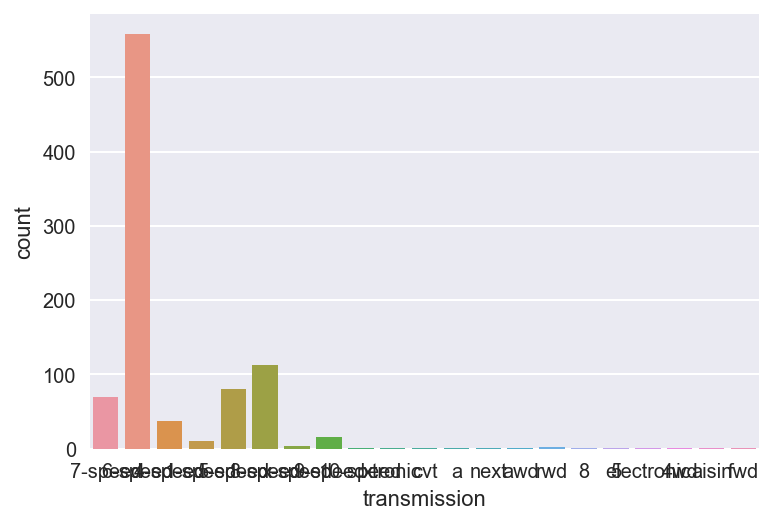

In [44]:
sns.countplot(df.transmission)

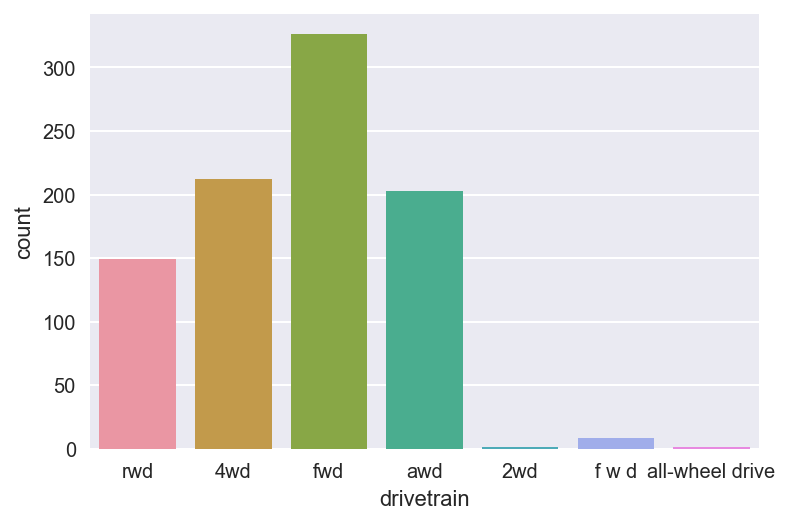

In [43]:
sns.countplot(df.drivetrain)

In [35]:
df["year"] = df["year"].astype('int')
df["mile"] = df["mile"].astype('int')
df["photos"] = df["photos"].astype('int')
df["video"] = df["video"].astype('int')
df["star"] = df["star"].astype('int')
df["review_no"] = df["review_no"].astype('int')
df["price"] = df["price"].astype('int')

In [36]:
pw = 

# write local car_info
engine = create_engine("mysql+mysqldb://root:" + pw + "@127.0.0.1/car_info")
df.to_sql(name="car_info", con=engine, if_exists='replace')

In [ ]:
y_train = np.log1p(df["price"].astype('int'))
X_train = df.drop('price', axis=1)

In [ ]:
y_train = pd.DataFrame(y_train, columns=['price'])

In [ ]:
# Divide into numeric and categorical variables
numerical_features = []
categorical_features = []
for f in X_train.columns:
    if X_train.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [ ]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)

In [ ]:
categorical_features = ['company', 'subname', 'exterior_color', 'interior_color', 'transmission', 'drivetrain']

In [ ]:
X_train = pd.get_dummies(df[categorical_features])

In [ ]:
X_train

In [ ]:
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# Setup the K-Fold
k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)

# Score list
scores = []

# max_depth_list
max_depth_list =[]
diff_list = []

pre_score = 0

# Change max_depth to check cross_varidation score
for max_depth in range(1,20):
    globals()['tree%s' % max_depth] = RandomForestClassifier(max_depth=max_depth, n_estimators=10).fit(X_train, y_train)
    score = cross_val_score(globals()['tree%s' % max_depth],X_train, y_train, cv=k_fold, n_jobs=-1, scoring="accuracy").mean()
    print('{}_cross_val_scroe:{}'.format('tree%s' % max_depth, score))
    scores.append(score)
    max_depth_list.append(max_depth)
    diff = score - pre_score 
    pre_score = score
    diff_list.append(diff)

plt.figure(figsize=(17,6))

plt.subplot(121)
plt.bar(max_depth_list[1:-1], diff_list[1:-1])
plt.ylabel('CV score fluctuation')
plt.xlabel('Max_depth')
plt.axhline(np.max(diff_list[1:-1]), linestyle=':', c = 'r', linewidth=4)

plt.subplot(122)
plt.bar(max_depth_list, scores)
plt.ylabel('CV score')
plt.xlabel('Max_depth')
diff_list_max_index = np.argmax(diff_list[1:-1]) + 2
plt.axvline(diff_list_max_index, linestyle=':', c = 'r', linewidth=4)

plt.show() 

In [ ]:
# Divide into numeric and categorical variables
numerical_features = []
categorical_features = []
for f in df.columns:
    if df.dtypes[f] != 'object':
        numerical_features.append(f)
    else:
        categorical_features.append(f)

In [ ]:
print("Numerical Features Qty :", len(numerical_features),"\n")
print("Numerical Features : ", numerical_features, "\n\n")
print("Categorical Features Qty :", len(categorical_features),"\n")
print("Categorical Features :", categorical_features)